In [1]:
import os
import json
import hydra
import numpy as np
import enreg.tools.general as g
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt
from omegaconf import DictConfig

In [ ]:
# hep.style.use(hep.styles.CMS)

In [38]:
data_zh = g.load_all_data( "/home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau")
data_z = g.load_all_data( "/home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/Z_Ztautau")


[1/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_202052.parquet
[2/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_201070.parquet
[3/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_200712.parquet
[4/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_200700.parquet
[5/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_202325.parquet
[6/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_200266.parquet
[7/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/SimpleDNN/test/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_201975.parquet
[8/994] Loading from /home/norman/ENREG/ntuples/240503_SDNN_DM/Simple

In [47]:
output_dir = os.path.join("/home/norman/DM_plots_zh")
os.makedirs(output_dir, exist_ok=True)

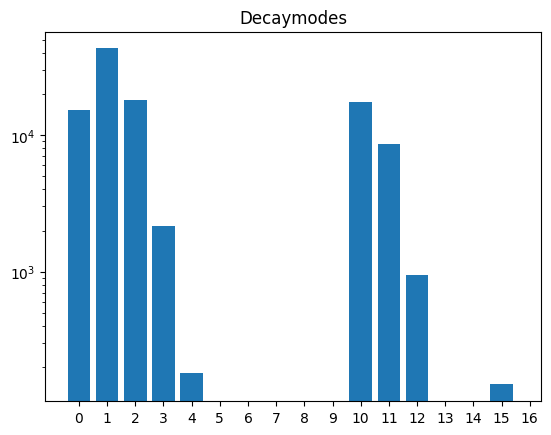

In [39]:
dms = np.arange(17)
plt.title("Decaymodes")
plt.hist(
    data_zh["gen_jet_tau_decaymode"], bins=dms,
    width=0.8
)
plt.yscale('log')
plt.xticks(dms+0.4, dms);

In [73]:
actual_zh = data_zh['gen_jet_tau_decaymode']
predicted_zh = data_zh['tau_dm']

actual_z = data_z['gen_jet_tau_decaymode']
predicted_z = data_z['tau_dm']

DM_labels = ['OneProng0PiZero', 'OneProng1PiZero', 'OneProng2PiZero', 'OneProng3PiZero', 'OneProngNPiZero',
             'ThreeProng0PiZero', 'ThreeProng1PiZero', 'ThreeProng2PiZero', 'RareDecayMode']
# DM_labels = [0, 1, 2, 3, 4, 10, 11, 12, 15]

In [42]:
from sklearn import metrics
import seaborn as sns

In [89]:
def CM_plot(actual, predicted, title, output_path):
    cm = metrics.confusion_matrix(actual, predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(17,15))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=DM_labels, yticklabels=DM_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.savefig(output_path)
    plt.close("all")
    plt.show(block=False)

In [90]:
CM_plot(
    actual = actual_zh,
    predicted = predicted_zh,
    title = 'DM Confusion matrix ZH',
    output_path = os.path.join(output_dir, "CM_zh.png")
    )

In [91]:
CM_plot(
    actual = actual_z,
    predicted = predicted_z,
    title = 'DM Confusion matrix Z',
    output_path = os.path.join(output_dir, "CM_z.png")
    )